In [1]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')
begin_start = time.time()

In [2]:
#file = "big_df_v2.csv"  #large file for production
file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [3]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [4]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           3358
shortDn           15
parentItemId      14
itemId            10
main_cat           0
sub_cat            0
catNode            0
longDn             0
categoryPath       0
name               0
dtype: int64

In [5]:
# Removing foreign language and Spanish titles. Attempting to show a better distribution of topics. Less noise.
df = df[df['sub_cat'] != 'Foreign Language Study & Reference Books']
df = df[df['sub_cat'] != 'Libros en Espanol']

In [6]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 45 categories of books.
4 categories have more than 100 books.


In [12]:
Top_40_cats = df.sub_cat.value_counts().iloc[:3].index.tolist()

# Print number of titles represented in each of the Top 40 categories #
print(df.sub_cat.value_counts().iloc[:39])


Arts & Entertainment Books            1227
Children's & Kids' Books               679
Business & Money Books                 467
Biographies & Memoirs                  453
Walmart Books Best Sellers              73
Religion & Spirituality Books           71
Literature & Fiction Books              60
History Books                           38
Back to School Books                    32
Crafts & Hobbies Books                  32
Self-Help Books                         28
Comic Books & Graphic Novels            26
Teen & Young Adult Books                26
Mother's Day Books                      21
Science & Nature Books                  19
Medical Books                           17
Arts & Entertainment                    17
Reference Books                         16
Cookbooks, Food & Wine                  16
Education Books                         13
Study Aids & Test Prep Books            12
Father's Day Books                      11
Humor Books                             11
Health & We

In [13]:
# Only keep records for top n populated categories (drop sparsely populated categories) #
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [14]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [15]:
import numpy as np
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Fancy LDA visualization tool
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable gensim logging 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])
#stop_words.extend(['book', 'new']) # decided extra stop words could be introducing bias 

In [17]:
# reviewing unique categories #
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books']


In [18]:
data = df.longDn.values.tolist()

In [19]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

In [20]:
# random check to ensure clean data
data[300]

'Groovy Mandalas Adult Coloring Book'

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [22]:
# Build the bigrams and trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [23]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [24]:
start = time.time()
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])
end = time.time()
print(end-start)

21.25982403755188


In [25]:
start = time.time()

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
end = time.time()
print(end-start)

0.39295053482055664


In [28]:
def run_model(topics=30, chunksize=50000, passes=50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=topics, 
                                               random_state=100,
                                               chunksize=chunksize,    # chunksize = number of docs to be used in each training chunk
                                               passes=passes,
                                               per_word_topics=True)

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis,'vis_' + str(topics) + '.html')
    vis
    return;



In [29]:
run_model(topics=12)


Perplexity:  -8.304035288037767

Coherence Score:  0.32041469071340695


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'timetest.html')
vis



# How many topics should we train? 

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



170.35961842536926


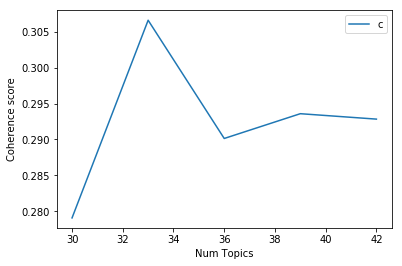

Num Topics = 30  has Coherence Value of 0.2791
Num Topics = 33  has Coherence Value of 0.3066
Num Topics = 36  has Coherence Value of 0.2901
Num Topics = 39  has Coherence Value of 0.2936
Num Topics = 42  has Coherence Value of 0.2928


In [40]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [41]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



148.81152534484863


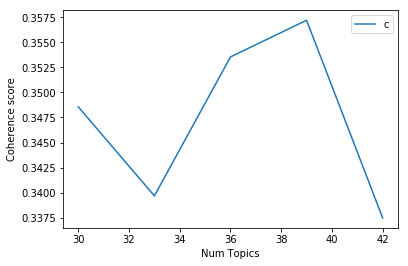

Num Topics = 30  has Coherence Value of 0.3486
Num Topics = 33  has Coherence Value of 0.3397
Num Topics = 36  has Coherence Value of 0.3535
Num Topics = 39  has Coherence Value of 0.3572
Num Topics = 42  has Coherence Value of 0.3375


In [42]:
# print graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df:   
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  
> Num Topics = 30  has Coherence Value of 0.5535  
> Num Topics = 33  has Coherence Value of 0.4843  
> Num Topics = 36  has Coherence Value of 0.4783  
> Num Topics = 39  has Coherence Value of 0.4902  
> Num Topics = 42  has Coherence Value of 0.4779  
      
  As expected (and unexplained) LDA Model performs better   
  than the LDA multicore model with identical parameters   



# Attempting high score: Topics: 30, chunks: 50k, passes=20

> New Best Model? Yes  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238   

added 'new' as stopword, coherence dropped to 0.603. Decision reversed.


In [43]:
# start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=20,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

1531580699.4669483

Perplexity:  -8.427456072314538

Coherence Score:  0.3434224926833715
1531580725.7755597


C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


1531580747.6725771


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
25     8.829552        1       1 -0.083754  0.133358
10     8.109394        1       2  0.019269  0.038572
13     4.888693        1       3  0.084254  0.001018
2      4.777709        1       4  0.102498 -0.007158
8      4.581992        1       5  0.129452 -0.037591
1      4.224825        1       6  0.089746 -0.011038
3      3.857564        1       7  0.120438 -0.052203
0      3.736215        1       8 -0.047705  0.076410
4      3.692521        1       9  0.046684  0.000906
29     3.617583        1      10 -0.012613  0.053249
12     3.539561        1      11  0.012215  0.046028
5      3.244511        1      12 -0.038548  0.097732
24     3.227096        1      13  0.032205 -0.008839
7      3.175322        1      14 -0.056819  0.078486
26     3.139985        1      15  0.055883  0.011076
27     3.066688        1      16  0.102259 -0.040220
9      2.871464        1      17 -0.032567  0.032326
16     2.795275        1      18 -0.088793  0.108705
28     2.787693        1      19 -0.022705 -0.004481
22     2.517116        1      20 -0.033411  0.000962
15     2.474164        1      21 -0.045588  0.031275
17     2.345889        1      22 -0.025389  0.002009
23     2.237200        1      23  0.047621 -0.061360
19     2.232910        1      24  0.103061 -0.105008
14     2.091955        1      25 -0.014056 -0.030643
20     1.976463        1      26 -0.026808  0.018330
21     1.807259        1      27 -0.057937 -0.027152
18     1.739333        1      28 -0.041637 -0.032098
11     1.476086        1      29 -0.248830 -0.224773
6      0.937984        1      30 -0.068424 -0.087879, topic_info=      Category         Freq           Term        Total  loglift  logprob
term                                                                     
644    Default   739.000000            art   739.000000  30.0000  30.0000
1863   Default   419.000000          color   419.000000  29.0000  29.0000
473    Default   465.000000           book   465.000000  28.0000  28.0000
984    Default   549.000000         artist   549.000000  27.0000  27.0000
1031   Default   668.000000         design   668.000000  26.0000  26.0000
21     Default  1418.000000            new  1418.000000  25.0000  25.0000
7407   Default   288.000000   architecture   288.000000  24.0000  24.0000
1165   Default    88.000000     junie_jone    88.000000  23.0000  23.0000
193    Default    97.000000    year_format    97.000000  22.0000  22.0000
459    Default   315.000000        student   315.000000  21.0000  21.0000
116    Default  1154.000000           time  1154.000000  20.0000  20.0000
16     Default   111.000000   harry_potter   111.000000  19.0000  19.0000
152    Default  1347.000000           life  1347.000000  18.0000  18.0000
1951   Default   321.000000           draw   321.000000  17.0000  17.0000
77     Default  1063.000000        include  1063.000000  16.0000  16.0000
124    Default   628.000000            use   628.000000  15.0000  15.0000
2834   Default   104.000000             la   104.000000  14.0000  14.0000
10205  Default    63.000000            und    63.000000  13.0000  13.0000
256    Default   273.000000       building   273.000000  12.0000  12.0000
289    Default   851.000000          story   851.000000  11.0000  11.0000
254    Default   200.000000      adventure   200.000000  10.0000  10.0000
1164   Default    73.000000          junie    73.000000   9.0000   9.0000
31     Default   460.000000         series   460.000000   8.0000   8.0000
847    Default   210.000000          black   210.000000   7.0000   7.0000
1293   Default   256.000000          house   256.000000   6.0000   6.0000
1848   Default   195.000000        drawing   195.000000   5.0000   5.0000
8237   Default   173.000000  architectural   173.000000   4.0000   4.0000
1364   Default   243.000000           team   243.000000   3.0000   3.0000
774    Default   295.000000          cove

# Attempting new high score: Topics: 30, chunks: 50k, passes=50

> New Best Model? Yes. Marginal improvement in Coherence Score (0.0034) by increasing from 20 to 50 passes.  
> Runtime: unclocked.   
> Perplexity: -8.609     
> Coherence Score: 0.6272     

added stopword 'new' and coherence decreased to 0.6078. Decision reversed.

In [ ]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


In [ ]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
pyLDAvis.save_html(vis,'vis_2_no_int.html')
print(end-start)
vis


# trying same best model, separate random state (100 -> 200)
Before:  
> Runtime: 3hrs 25 minutes (12,209 seconds).   
> Perplexity: -8.609     
> Coherence Score: 0.6272    
 
After (random state changed to 200):  
> Runtime: 2hrs 15min (8,111 seconds)  
> Perplexity: -8.603    
> Coherence Score: 0.611      

Results: Similar score, no improvement.

In [59]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


194.9738063812256

Perplexity:  -8.380236239451493

Coherence Score:  0.34775977362145344
219.58585262298584


In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis
pyLDAvis.save_html(vis,'vis30_no_int.html')

238.66015005111694


In [48]:
# applying topics to docs in corpus
lda_corpus = lda_model[corpus]


In [49]:
# Printing total runtime. Only relevant on full run. #
final_end = time.time()
print(final_end - begin_start)

1018.3138537406921


In [57]:
df[df['longDn'].str.contains(" der")]


,name,categoryPath,shortDn,longDn,model,catNode,itemId,parentItemId,sub_cat,main_cat
103,Darker: Fifty Shades Darker as Told by Christian,Books/Literature & Fiction Books/Fiction Novel...,"\\""\""Fifty shades darker as told by Christian\...",E L James revisits the world of Fifty Shades w...,NaN,3920_582105_9435716,404017163.0,404017163.0,Literature & Fiction Books,Books
108,"Zolpidem, Zopiclone Et Conduite Automobile de ...",Books/Medical Books/Pharmacology,"Zolpidem, Zopiclone Et Conduite Automobile de ...","L'insomnie, dÃ©finie comme un manque subjectif...",NaN,3920_3203859_8756084,53665467.0,53665467.0,Medical Books,Books
214,Time to Be a Hero,Books/Children's & Kids' Books/Leveled Readers...,Join your favorite heroes as they work togethe...,Join your favorite heroes as they work togethe...,NaN,3920_582053_1106635,53597237.0,53597237.0,Children's & Kids' Books,Books
245,Game of Thrones Paperback Boxed Set,Books/Literature & Fiction Books/Fiction Novel...,US,The perfect gift for fans of HBO's Game of Thr...,9780345535528,3920_582105_9435716,20664829.0,20664829.0,Literature & Fiction Books,Books
249,Darker: Fifty Shades Darker as Told by Christian,Books/Literature & Fiction Books/Fiction Novel...,"\\""\""Fifty shades darker as told by Christian\...",E L James revisits the world of Fifty Shades w...,NaN,3920_582105_9435716,404017163.0,404017163.0,Literature & Fiction Books,Books
323,Time to Be a Hero,Books/Children's & Kids' Books/Leveled Readers...,Join your favorite heroes as they work togethe...,Join your favorite heroes as they work togethe...,NaN,3920_582053_1106635,53597237.0,53597237.0,Children's & Kids' Books,Books
363,Game of Thrones Paperback Boxed Set,Books/Literature & Fiction Books/Fiction Novel...,US,The perfect gift for fans of HBO's Game of Thr...,9780345535528,3920_582105_9435716,20664829.0,20664829.0,Literature & Fiction Books,Books
366,George R. R. Martin's A Game of Thrones 5-Book...,Books/Literature & Fiction Books/Fiction Novel...,Details Coming Soon,The perfect gift for fans of HBOâsÂ Game of ...,NaN,3920_582105_9435716,20664828.0,20664828.0,Literature & Fiction Books,Books
378,Game of Thrones Leather-Cloth Boxed Set (Song ...,Books/Literature & Fiction Books/Fiction Novel...,A box set includes the first five books in the...,The perfect gift for fans of the epic fantasy ...,NaN,3920_582105_9435716,45761465.0,45761465.0,Literature & Fiction Books,Books
512,Misoprostol En La Interrupcion Temprana del Em...,Books/Medical Books/General,Misoprostol en la interrupci?n temprana del em...,"En la actualidad, la poblacion adolescente rep...",NaN,3920_3203859_9280261,53659769.0,53659769.0,Medical Books,Books
